In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import required libraries.**

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet_v2,MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,Activation, Conv2DTranspose, Concatenate,Reshape,ZeroPadding2D, Convolution2D,MaxPooling2D, Dense,Flatten,Softmax,Dropout
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
import pandas as pd
import requests
import glob
import os
import shutil
import zipfile
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# Standarize features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,img_to_array, array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K


### **PART - A**

• **DOMAIN:** Entertainment

• **CONTEXT:** Company X owns a movie application and repository whichn caters movie streaming to millions of users who on subscription basis Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done.

Since there higher time complexity is involved in the

• **DATA DESCRIPTION:** The dataset comprises of images and its mask for corresponding human face.

• **PROJECT OBJECTIVE:** To build a face detection system.

### 1. Import and Understand the data.

#### **1.A. Import and read 'images.npy'.**

In [4]:
file_path = '/content/drive/MyDrive/AIML DATASETS/images.npy'

img_arr = np.load(file_path, allow_pickle=True)

In [5]:
# Print the shape of the image
print("Images shape:" , img_arr.shape)

Images shape: (409, 2)


There are total 409 images and each images contain image array & bounary box points

In [6]:
print(img_arr[1])

[array([[[207, 216, 227, 255],
         [206, 216, 227, 255],
         [207, 216, 227, 255],
         ...,
         [ 35,  33,  34, 255],
         [ 35,  33,  34, 255],
         [ 35,  33,  34, 255]],

        [[207, 216, 227, 255],
         [207, 216, 227, 255],
         [207, 216, 227, 255],
         ...,
         [ 35,  32,  33, 255],
         [ 35,  33,  34, 255],
         [ 35,  33,  34, 255]],

        [[207, 216, 227, 255],
         [207, 216, 227, 255],
         [207, 215, 227, 255],
         ...,
         [ 35,  33,  33, 255],
         [ 35,  33,  34, 255],
         [ 35,  33,  34, 255]],

        ...,

        [[ 31,  21,  17, 255],
         [ 31,  22,  18, 255],
         [ 31,  22,  18, 255],
         ...,
         [  0,   1,   4, 255],
         [  0,   1,   4, 255],
         [  0,   1,   4, 255]],

        [[ 31,  22,  18, 255],
         [ 31,  22,  18, 255],
         [ 31,  22,  18, 255],
         ...,
         [  0,   1,   4, 255],
         [  0,   1,   4, 255],
         

In [7]:
print(img_arr[185,0])

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


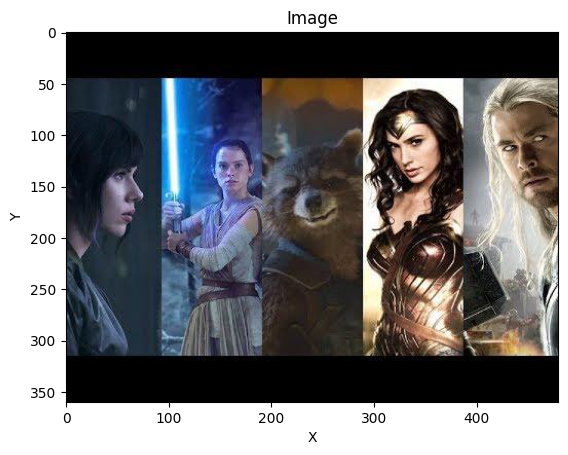

In [8]:
# Get the pixel values
pixel_values = img_arr[185,0]

# Create a new figure
fig, ax = plt.subplots()

# Plot the image
ax.imshow(pixel_values)

# Set the title and axes labels
ax.set_title('Image')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

#### **1.B. Split the data into Features(X) & labels(Y). Unify shape of all the images.**

Imp Note: Replace all the pixels within masked area with 1.

Hint: X will comprise of array of image whereas Y will comprise of coordinates of the mask(human face). Observe: data[0], data[0][0], data[0][1].

In [9]:
# Seperate the images and its label into two different array
images = img_arr[:,0]
mask = img_arr[:,1]

In [10]:
print(images.shape)
print(mask.shape)

(409,)
(409,)


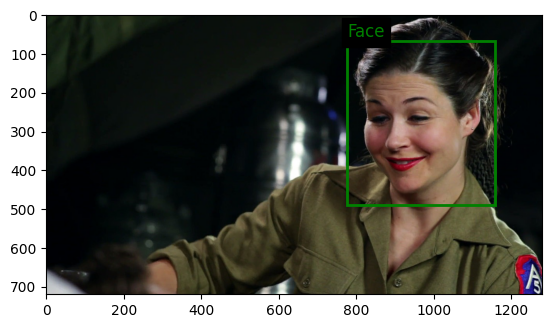

In [11]:
# Pick a random image number
img_num = np.random.randint(0, mask.shape[0])

# Read bounding box information
bounding_boxes = mask[img_num]

# Read the image
rand_img = images[img_num]

# Plot the image
plt.imshow(rand_img)

# Draw bounding boxes and labels
for obj in bounding_boxes:
    label = obj['label'][0]
    points = obj['points']
    x_min, y_min = points[0]['x'], points[0]['y']
    x_max, y_max = points[1]['x'], points[1]['y']

    # Calculate coordinates in terms of image dimensions
    h, w, _ = rand_img.shape
    x_min, y_min = int(x_min * w), int(y_min * h)
    x_max, y_max = int(x_max * w), int(y_max * h)

    # Draw bounding box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         fill=False, edgecolor='g', linewidth=2)
    plt.gca().add_patch(rect)

    # Add label - class name
    plt.text(x_min, y_min - 10, label, color='g', fontsize=12, backgroundcolor='black')

# Show the image with bounding boxes and labels
plt.show()

In [12]:
# set the default size is 224x224
IMG_WIDTH =224
IMG_HEIGHT=224

In [14]:
# Resize the image and change the points in the bounding box to 1.
X = np.zeros((int(images.shape[0]),IMG_HEIGHT, IMG_WIDTH, 3))
y = np.zeros((int(images.shape[0]),IMG_HEIGHT, IMG_WIDTH))
from PIL import Image
for index in range(len(images)):
  img = images[index];
  img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in range(len(mask[index])):
    obj = mask[index][i]
    w = obj['imageWidth']
    h = obj['imageHeight']
    w_scale = IMG_WIDTH
    h_scale = IMG_HEIGHT
    x_min = int(obj['points'][0]['x']*w_scale)
    y_min = int(obj['points'][0]['y']*h_scale)
    x_max = int(obj['points'][1]['x']*w_scale)
    y_max = int(obj['points'][1]['y']*h_scale)
    y[index][y_min:y_max, x_min:x_max] = 1

In [15]:
# Prepare X and y and print its shape
print(X.shape)
print(y.shape)

(409, 224, 224, 3)
(409, 224, 224)


#### **1.C. Split the data into train and test[400:9].**

In [16]:
X_train = X[0:400]
y_train =  y[0:400]

X_test = X[400:409]
y_test = y[400:409]

#### **1.D. Select random image from the train data and display original image and masked image.**

image number  83


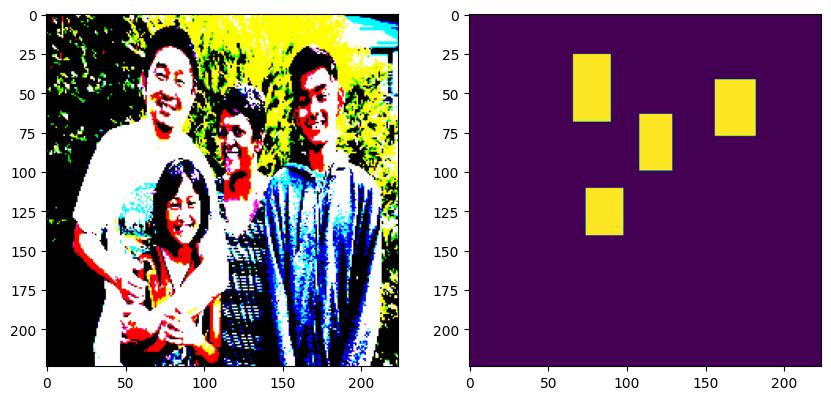

In [32]:
img_num = np.random.randint(0, X_train.shape[0])
print('image number ', img_num)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cv2.cvtColor(X_train[img_num].astype('float32'), cv2.COLOR_BGR2RGB))
ax[1].imshow(y_train[img_num])

### 2. Model building.

#### **2.A. Design a face mask detection model.**


In [33]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = conv_block(x, num_filters)
    return x

def buildMobileNet_v2_unet(input_shape, trainable=False):
    inputs = Input(shape=input_shape)
    encoder = MobileNetV2(input_tensor=inputs, include_top=False, alpha=0.35, weights="imagenet")
    for layer in encoder.layers:
        layer.trainable = trainable

    s1 = inputs
    s2 = encoder.get_layer("block_1_expand_relu").output
    s3 = encoder.get_layer("block_3_expand_relu").output
    s4 = encoder.get_layer("block_6_expand_relu").output
    b1 = encoder.get_layer("block_13_expand_relu").output

    d1 = decoder_block(b1, s4, 64)
    d2 = decoder_block(d1, s3, 48)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="mobileNetV2_U-Net")
    return model

model = buildMobileNet_v2_unet((224, 224, 3))
model.summary()

2019640/2019640 [==============================] - 1s 1us/step
Model: "mobileNetV2_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 16)         432       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 16)         64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU) 

### **2.B. Design your own Dice Coefficient and Loss function.**

In [34]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
model.compile(optimizer='adam', loss=dice_loss, metrics = ["acc", dice_coef, Recall(), Precision()])

#### **2.C. Train and tune the model as required.**

In [35]:
checkpoint = ModelCheckpoint("Q1/model.h5", monitor="val_loss", verbose=1, save_best_only=True,
                              mode="min")
stop = EarlyStopping(monitor="val_loss", patience=7, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [36]:
BATCH = 8
train_steps = len(X_train)//BATCH
valid_steps = len(X_test)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_test) % BATCH != 0:
    valid_steps += 1
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[checkpoint,reduce_lr,stop]
)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.7589 - acc: 0.5270 - dice_coef: 0.2411 - recall: 0.6865 - precision: 0.1660
Epoch 1: val_loss improved from inf to 0.80487, saving model to Q1/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 28s 141ms/step - loss: 0.7589 - acc: 0.5270 - dice_coef: 0.2411 - recall: 0.6865 - precision: 0.1660 - val_loss: 0.8049 - val_acc: 0.1160 - val_dice_coef: 0.1921 - val_recall: 1.0000 - val_precision: 0.1083 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.6585 - acc: 0.6774 - dice_coef: 0.3415 - recall: 0.8128 - precision: 0.2546
Epoch 2: val_loss improved from 0.80487 to 0.78247, saving model to Q1/model.h5
50/50 [==============================] - 3s 65ms/step - loss: 0.6585 - acc: 0.6774 - dice_coef: 0.3415 - recall: 0.8128 - precision: 0.2546 - val_loss: 0.7825 - val_acc: 0.2372 - val_dice_coef: 0.2142 - val_recall: 1.0000 - val_precision: 0.1234 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.5638 - acc: 0.8174 - dice_coef: 0.4362 - recall: 0.7617 - precision: 0.3854
Epoch 3: val_loss improved from 0.78247 to 0.73752, saving model to Q1/model.h5
50/50 [===================

#### **2.D. Evaluate and share insights on performance of the model.**

In [37]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

2/2 [==============================] - 0s 25ms/step - loss: 0.4361 - acc: 0.9113 - dice_coef: 0.5685 - recall: 0.5142 - precision: 0.6019


[0.4360545575618744,
 0.9113231897354126,
 0.5685065984725952,
 0.5142415165901184,
 0.6018683910369873]

- **Loss:** Loss is a measure of how well the model is performing. It represents an error value that the model is trying to minimize during training. In this case, the loss value is 0.4361, which suggests that the model is reasonably accurate, with lower values indicating better performance.

- **Accuracy (acc):** Accuracy represents the proportion of correctly classified samples out of the total samples. An accuracy of 0.9113 (or approximately 91.13%) indicates that the model correctly predicted the class of 91.13% of the input data.

- **Dice Coefficient (dice_coef):** The Dice coefficient is commonly used in image segmentation tasks to measure the overlap between the predicted segmentation and the ground truth. A value of 0.5685 suggests that more than half of the predicted pixels overlap with the ground truth, indicating moderate performance in segmentation tasks.

- **Recall:** Recall, also known as sensitivity, is the ratio of correctly predicted positive observations to all actual positives. It measures the model's ability to identify all relevant cases in the data. A recall value of 0.5142 means the model correctly identified about 51.42% of all positive cases.

- **Precision:** Precision is the ratio of correctly predicted positive observations to the total predicted positives. It measures the accuracy of the positive predictions. A precision value of 0.6019 indicates that about 60.19% of the predicted positive cases were correct.


In summary, the model seems to have a high overall accuracy (91.13%), but its performance in specific areas like recall (sensitivity) and dice coefficient (segmentation accuracy) could be further improved, especially if the application demands higher sensitivity or precision. It's important to consider the specific requirements of the task and fine-tune the model or experiment with different architectures and hyperparameters to achieve the desired performance.

#### **3. Test the model predictions on the test image: 'image with index 3 in the test data' and visualise the predicted masks on the faces in the image.**

In [38]:
def preprocess_image(image):
    return np.expand_dims(image, axis=0)

def generate_predicted_mask(model, image):
    scaled_image = preprocess_image(image)
    predicted_mask = cv2.resize((1.0 * (model.predict(scaled_image)[0] > 0.4)), (IMG_WIDTH, IMG_WIDTH))
    return predicted_mask

def display_model_prediction(img_num, X_test, y_test, model, IMG_WIDTH):
    test_img = X_test[img_num]
    pred_mask = generate_predicted_mask(model, test_img)

    masked_image = test_img.copy()
    masked_image[:, :, 0] *= pred_mask
    masked_image[:, :, 1] *= pred_mask
    masked_image[:, :, 2] *= pred_mask

    fig, axes = plt.subplots(1, 4, figsize=(12, 8))
    axes[0].set_title('Seismic')
    axes[0].imshow(cv2.cvtColor(test_img.astype('float32'), cv2.COLOR_BGR2RGB), cmap='seismic', interpolation='bilinear')

    axes[1].set_title('Actual Mask')
    axes[1].imshow(y_test[img_num], cmap='gray', interpolation='bilinear')

    axes[2].set_title('Predicted face')
    axes[2].imshow(cv2.cvtColor(masked_image.astype('float32'), cv2.COLOR_BGR2RGB), alpha=1)

    axes[3].set_title('Predicted Mask')
    axes[3].imshow(pred_mask, alpha=1)

    plt.show()

1/1 [==============================] - 1s 1s/step


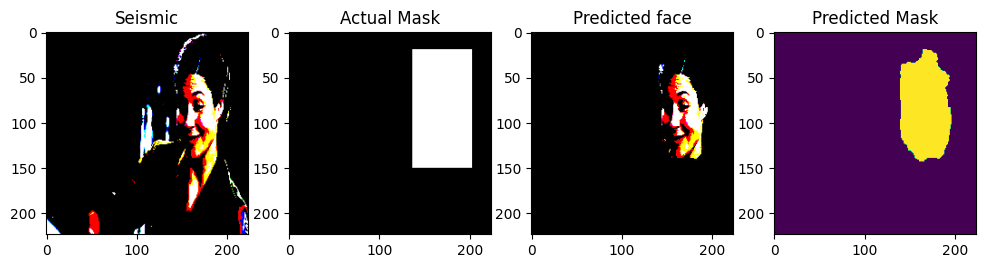

In [39]:
display_model_prediction(5, X_test, y_test, model, IMG_WIDTH)

### **Part - B**

• **DOMAIN:** Entertainment

• **CONTEXT:** Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

The data labelling is already done. Since there higher time complexity is involved in the

• **DATA DESCRIPTION:** The dataset comprises of face images.

• **PROJECT OBJECTIVE:** To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

 #### **1. Read/import images from folder 'training_images'.**

In [41]:
# Source file path
source_file = '/content/drive/MyDrive/AIML DATASETS/training_images-20211126T092819Z-001.zip'

# Destination folder path (in this case, the current directory)
destination_folder = './'

# Copy the file from the source to the destination
shutil.copy(source_file, destination_folder)

# Unzip the copied ZIP file
zip_file_path = os.path.join(destination_folder, 'training_images-20211126T092819Z-001.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# List the extracted files
    extracted_files = zip_ref.namelist()
    print("Extracted files:")
    for file in extracted_files:
        print(file)

Extracted files:
training_images/real_00947.jpg
training_images/real_01052.jpg
training_images/real_01042.jpg
training_images/real_00964.jpg
training_images/real_01053.jpg
training_images/real_00971.jpg
training_images/real_01057.jpg
training_images/real_01044.jpg
training_images/real_01041.jpg
training_images/real_01067.jpg
training_images/real_00969.jpg
training_images/real_00956.jpg
training_images/real_00975.jpg
training_images/real_01021.jpg
training_images/real_00945.jpg
training_images/real_01068.jpg
training_images/real_01062.jpg
training_images/real_01016.jpg
training_images/real_01065.jpg
training_images/real_01027.jpg
training_images/real_00961.jpg
training_images/real_01014.jpg
training_images/real_01010.jpg
training_images/real_00952.jpg
training_images/real_00951.jpg
training_images/real_00981.jpg
training_images/real_01050.jpg
training_images/real_00962.jpg
training_images/real_00995.jpg
training_images/real_01056.jpg
training_images/real_00977.jpg
training_images/real_0

#### **2. Write a loop which will iterate through all the images in the 'training_images' folder and detect the faces present on all the images.**

Hint: You can use 'haarcascade_frontalface_default.xml' from internet to detect faces which is available open source.

In [42]:
# Iterate over all the images and converted into array
images = glob.glob('training_images/*.jpg')
img_list = [cv2.imread(img) for img in images]
img_list_arr = np.array(img_list)

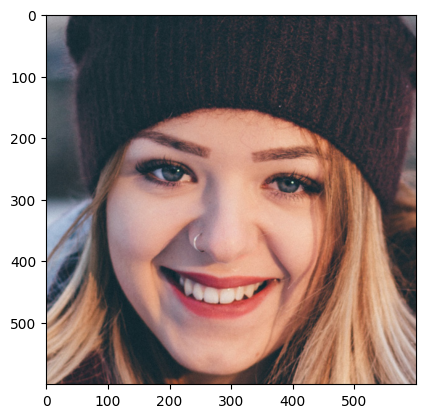

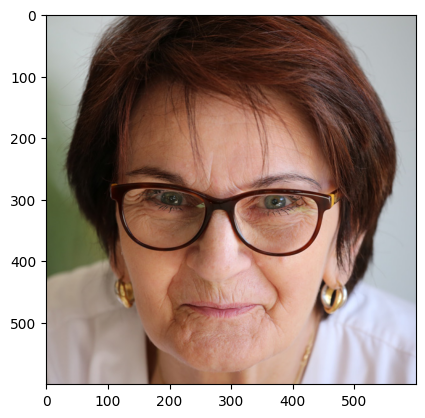

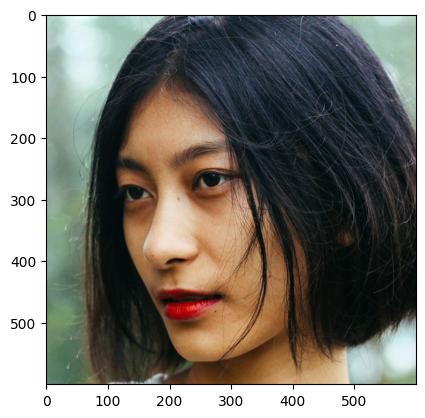

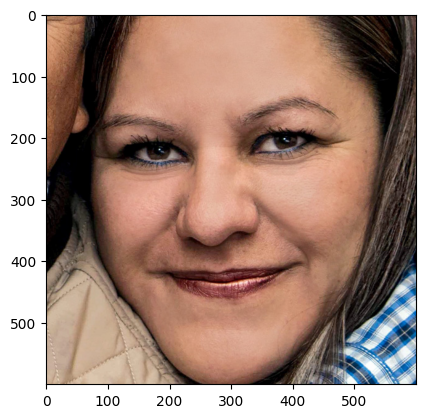

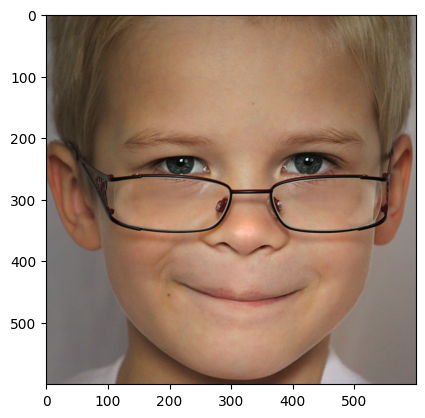

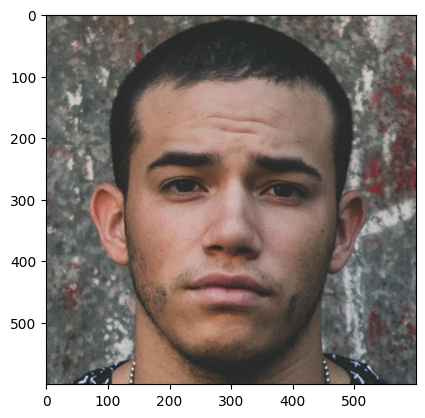

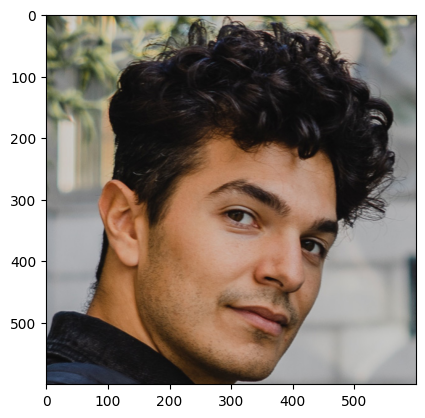

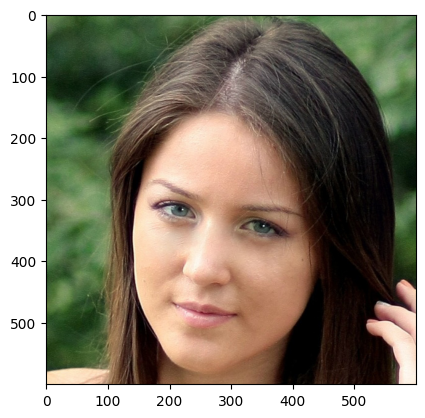

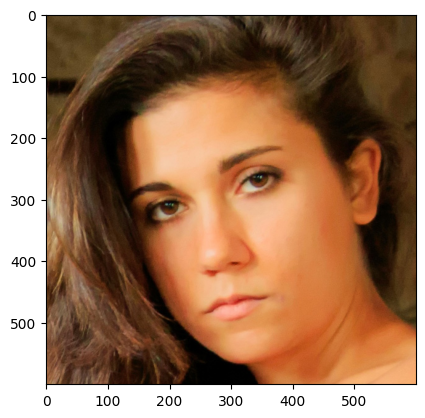

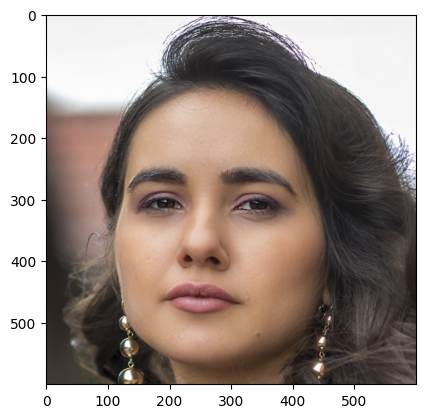

In [43]:
# Take random image and print image
img_nums = np.random.randint(0, len(img_list)-1, 10)
for img_num in img_nums:
  plt.imshow(cv2.cvtColor(img_list[img_num], cv2.COLOR_BGR2RGB))
  plt.show()

In [44]:
# print the shape of array.
print(img_list_arr.shape)

(1091, 600, 600, 3)


In [45]:
# URL of the file to be downloaded
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

# Send an HTTP request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content
    with open("haarcascade_frontalface_default.xml", "wb") as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully.


X-min : 69, y-min : 136, width : 437, height: 437


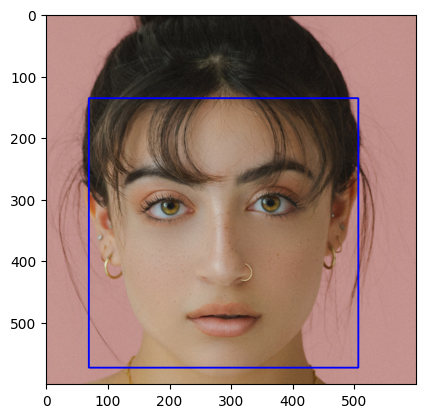

In [48]:
# Take random image and print the bounding boxes on the image
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
test_img = img_list[np.random.randint(0, len(img_list)-1)]
grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(grey,1.1,4)

for (x,y,w,h) in faces:
  cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
  print("X-min : {}, y-min : {}, width : {}, height: {}".format(x, y,w,h) )
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [49]:
#Prepare a dataframe that contain cordinates of bounding boxes. It contain x cordinate, y cordinate, width, height, Total number of faces in an image and image size.
#In case, if an image contains multiple faces, multiple entries will be created for the same image with different face cordinates
face_img_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
face_img_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

Iterate over each faces and put it into the dataframe

In [50]:
defected_images = []
undefected_images = []

for index, img in enumerate(img_list):
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(grey,1.1,4)
  if len(faces)==0:
    undefected_images.append(img);
    df2 = {'x': 0, 'y': 0, 'w': -1, 'h':-1, 'Total_Faces': 0, 'Image_Name': images[index].split("/")[1]}
  else:
    defected_images.append(img)
    for (x,y,w,h) in faces:
      cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
      df2 = {'x': x, 'y': y, 'w': w, 'h':h, 'Total_Faces': len(faces), 'Image_Name': images[index].split("/")[1]}
  face_img_df = pd.concat([face_img_df, pd.DataFrame([df2])], ignore_index=True)
print("Total Undefected Face images are : {}".format(len(undefected_images)))
print("Total defected Face images are : {}".format(len(defected_images)))

Total Undefected Face images are : 161
Total defected Face images are : 930


#### **3. From the same loop above, extract metadata of the faces and write into a DataFrame.**

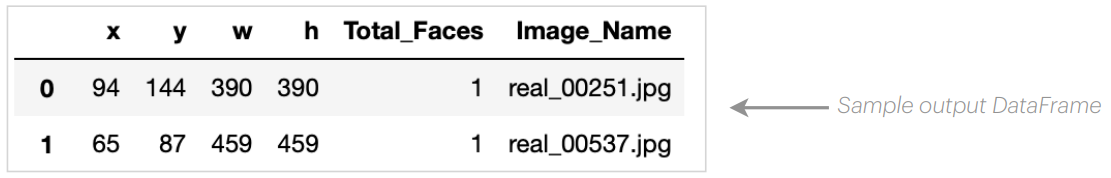

In [51]:
face_img_df

x    y    w    h Total_Faces      Image_Name
0      23  147  437  437           1  real_00944.jpg
1      50  157  419  419           1  real_00564.jpg
2      77  113  404  404           1  real_01066.jpg
3     186  146  363  363           1  real_00050.jpg
4      73  119  429  429           1  real_00233.jpg
...   ...  ...  ...  ...         ...             ...
1086  108  180  401  401           1  real_00317.jpg
1087   26   39  441  441           1  real_00419.jpg
1088    0    0   -1   -1           0  real_00366.jpg
1089   79  155  385  385           2  real_00735.jpg
1090    0    0   -1   -1           0  real_00007.jpg

[1091 rows x 6 columns]

**Images that have 0 bounding box**

In [52]:
face_img_df[face_img_df.Total_Faces == 0]

x  y   w   h Total_Faces      Image_Name
14    0  0  -1  -1           0  real_00853.jpg
19    0  0  -1  -1           0  real_00364.jpg
20    0  0  -1  -1           0  real_00056.jpg
22    0  0  -1  -1           0  real_00320.jpg
25    0  0  -1  -1           0  real_00198.jpg
...  .. ..  ..  ..         ...             ...
1069  0  0  -1  -1           0  real_00705.jpg
1071  0  0  -1  -1           0  real_00627.jpg
1082  0  0  -1  -1           0  real_00097.jpg
1088  0  0  -1  -1           0  real_00366.jpg
1090  0  0  -1  -1           0  real_00007.jpg

[161 rows x 6 columns]

In [53]:
images_that_have_0_bounding_box= np.unique(face_img_df[face_img_df.Total_Faces == 0].Image_Name)
print("Total number of unique images that have 0 bounding box:", len(images_that_have_0_bounding_box))

Total number of unique images that have 0 bounding box: 161


**Images that have 1 bounding box**

In [54]:
face_img_df[face_img_df.Total_Faces ==1]

x    y    w    h Total_Faces      Image_Name
0      23  147  437  437           1  real_00944.jpg
1      50  157  419  419           1  real_00564.jpg
2      77  113  404  404           1  real_01066.jpg
3     186  146  363  363           1  real_00050.jpg
4      73  119  429  429           1  real_00233.jpg
...   ...  ...  ...  ...         ...             ...
1083   53  108  401  401           1  real_00114.jpg
1084  141  188  378  378           1  real_00062.jpg
1085   62  122  460  460           1  real_00427.jpg
1086  108  180  401  401           1  real_00317.jpg
1087   26   39  441  441           1  real_00419.jpg

[855 rows x 6 columns]

In [55]:
images_that_have_1_bounding_box= np.unique(face_img_df[face_img_df.Total_Faces == 1].Image_Name)
print("Total number of unique images that have 1 bounding box:", len(images_that_have_1_bounding_box))

Total number of unique images that have 1 bounding box: 855


**Images that have more than 1 bounding box**

In [56]:
face_img_df[face_img_df.Total_Faces >1]

x    y    w    h Total_Faces      Image_Name
15    134  175  374  374           2  real_00305.jpg
16     68  145  395  395           2  real_00864.jpg
28     67  435   57   57           2  real_00428.jpg
41    160  151  398  398           2  real_00372.jpg
42    454  232  109  109           2  real_00518.jpg
...   ...  ...  ...  ...         ...             ...
965    10  459  115  115           2  real_00647.jpg
994   287  419   62   62           2  real_00706.jpg
1020  161  141  392  392           2  real_00045.jpg
1078  501  405   52   52           3  real_00905.jpg
1089   79  155  385  385           2  real_00735.jpg

[75 rows x 6 columns]

In [57]:
images_morethan_1_bounding_boxes= np.unique(face_img_df[face_img_df.Total_Faces >1].Image_Name)
print("Total unique images that have more than 1 bounding box:", len(images_morethan_1_bounding_boxes))

Total unique images that have more than 1 bounding box: 75


**Images that have 2 bounding boxes**

In [58]:
face_img_df[face_img_df.Total_Faces ==2]

x    y    w    h Total_Faces      Image_Name
15    134  175  374  374           2  real_00305.jpg
16     68  145  395  395           2  real_00864.jpg
28     67  435   57   57           2  real_00428.jpg
41    160  151  398  398           2  real_00372.jpg
42    454  232  109  109           2  real_00518.jpg
...   ...  ...  ...  ...         ...             ...
957   126  163  418  418           2  real_00358.jpg
965    10  459  115  115           2  real_00647.jpg
994   287  419   62   62           2  real_00706.jpg
1020  161  141  392  392           2  real_00045.jpg
1089   79  155  385  385           2  real_00735.jpg

[69 rows x 6 columns]

In [59]:
images_that_have_2_bounding_boxes= np.unique(face_img_df[face_img_df.Total_Faces == 2].Image_Name)
print("Total number of unique images that have 2 bounding boxes:", len(images_that_have_2_bounding_boxes))

Total number of unique images that have 2 bounding boxes: 69


**Images that have more than 2 bounding boxes**

In [60]:
face_img_df[face_img_df.Total_Faces >2]

x    y    w    h Total_Faces      Image_Name
242    22  504   75   75           3  real_00980.jpg
342    13  562   28   28           3  real_00049.jpg
363   100  217  332  332           3  real_00837.jpg
763   134  173  356  356           3  real_00004.jpg
902    81  249  139  139           3  real_00730.jpg
1078  501  405   52   52           3  real_00905.jpg

In [61]:
images_morethan_2_bounding_boxes= np.unique(face_img_df[face_img_df.Total_Faces >2].Image_Name)
print("Total unique images that have more than 2 bounding boxes:", len(images_morethan_2_bounding_boxes))

Total unique images that have more than 2 bounding boxes: 6


Observation :  

- There are a total of 1,091 images.
- Some images contain more than one bounding box.
- Several images do not have any bounding boxes.
- Among the images with bounding boxes, 855 have only one bounding box.
- Additionally, 69 images contain two bounding boxes, while 75 images have more than one bounding box. Specifically, 6 images have more than two bounding boxes.

#### **4. Save the output Dataframe in .csv format.**

In [62]:
face_img_df.to_csv("Images_Face.csv", index=False)
print("Dataframe has been saved in CSV format")

Dataframe has been saved in CSV format


In [63]:
# Cross Checking
img_df = pd.read_csv('Images_Face.csv')
img_df

x    y    w    h  Total_Faces      Image_Name
0      23  147  437  437            1  real_00944.jpg
1      50  157  419  419            1  real_00564.jpg
2      77  113  404  404            1  real_01066.jpg
3     186  146  363  363            1  real_00050.jpg
4      73  119  429  429            1  real_00233.jpg
...   ...  ...  ...  ...          ...             ...
1086  108  180  401  401            1  real_00317.jpg
1087   26   39  441  441            1  real_00419.jpg
1088    0    0   -1   -1            0  real_00366.jpg
1089   79  155  385  385            2  real_00735.jpg
1090    0    0   -1   -1            0  real_00007.jpg

[1091 rows x 6 columns]

### **Part - C**

- **DOMAIN:** Face Recognition
- **CONTEXT:** Company X intends to build a face identification model to recognise human faces.
- **DATA DESCRIPTION:** The dataset comprises of images and its mask where there is a human face.
- **PROJECT OBJECTIVE:** Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:


#### **1. Unzip, read and Load data('PINS.zip') into session.**

In [65]:
# Copy the PINS.Zip to google colab machine
shutil.copyfile("/content/drive/MyDrive/AIML DATASETS/PINS.zip", "PINS.zip")

# Copy the weights into google colab machine
weights_file = "vgg_face_weights.h5"
shutil.copyfile("/content/drive/MyDrive/AIML DATASETS/vgg_face_weights.h5", weights_file)

# Unzip the folder into google colab
shutil.unpack_archive("PINS.zip")

In [66]:
# Get the contents of the PINS directory
pins_dir = "PINS"
pins_contents = os.listdir(pins_dir)

# Print the contents of the directory
for item in pins_contents:
    # Get the file size and permissions
    file_size = os.path.getsize(os.path.join(pins_dir, item))
    file_permissions = os.stat(os.path.join(pins_dir, item)).st_mode

    # Print the file information
    print(f"{file_size:10} {oct(file_permissions):10} {item}")

      4096 0o40755    pins_robert downey jr face
      4096 0o40755    pins_Melissa benoit
      4096 0o40755    pins_Bryan Cranston
      4096 0o40755    pins_Neil Patrick Harris
     12288 0o40755    pins_anne hathaway
      4096 0o40755    pins_Jesse Eisenberg
      4096 0o40755    pins_Betsy Brandt
      4096 0o40755    pins_Morgan Freeman
     12288 0o40755    pins_margot robbie face
      4096 0o40755    pins_Jason Momoa
      4096 0o40755    pins_Mark Ruffalo
     12288 0o40755    pins_alexandra daddario
     12288 0o40755    pins_Emilia Clarke
     12288 0o40755    pins_elizabeth olsen face
      4096 0o40755    pins_Ursula Corbero
      4096 0o40755    pins_brie larson
     12288 0o40755    pins_Morena Baccarin
      4096 0o40755    pins_Mike Colter
      4096 0o40755    pins_Caity Lotz
      4096 0o40755    pins_Chris Pratt
     12288 0o40755    pins_Brenton Thwaites
      4096 0o40755    pins_RJ Mitte
      4096 0o40755    pins_david mazouz
      4096 0o40755    pins_jason i

#### **2. Write function to create metadata of the image.**

In [67]:
metaInformation_df = pd.DataFrame(columns=['Image_Name', 'Path', 'Label'])

def addMetaInformationtoDataFrame(subdir, file):
    global metaInformation_df
    df2 = pd.DataFrame({'Image_Name': [file], 'Path': [os.path.join(subdir, file)], 'Label': [subdir.split("/")[2].split('_')[1]]})
    metaInformation_df = pd.concat([metaInformation_df, df2], ignore_index=True)

In [68]:
# Load image using cv2 and convert it into RGB format
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

In [69]:
# Display the image by fetching the image number from the dataframe and load image using the path present in the dataframe
def displayImage(image_num):
  img_path = metaInformation_df.loc[image_num, "Path"]
  label =  metaInformation_df.loc[image_num, "Label"]
  img = load_image(img_path)
  fig = plt.figure(figsize = (15, 7.2))
  ax = fig.add_subplot(1, 1, 1)
  ax.set_title(label, fontsize = 20)
  plt.imshow(img);

#### **3. Write a loop to iterate through each and every image and create metadata for all the images.**

In [70]:
# Specified the root directory and iterate it over each file and creating metadata information
rootdir = './PINS'
for subdir, dirs, files in os.walk(rootdir):
  for file in files:
    addMetaInformationtoDataFrame(subdir, file)

In [71]:
#Check the total number of records in the meta data dataframe
print("Total number of records " , len(metaInformation_df))

Total number of records  10770


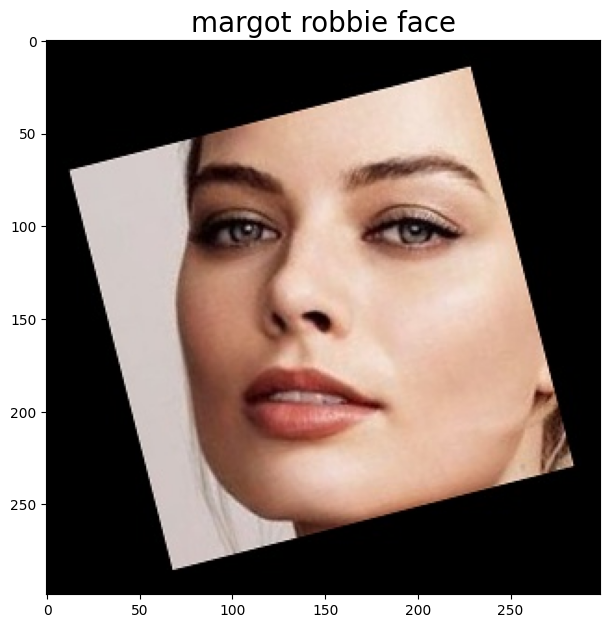

In [91]:
# Select any random number and load the image
n = np.random.randint(0, len(metaInformation_df)-1)
displayImage(n)

In [92]:
# count the total number of unique label present in the dataframe
print("Total number of unique labels :", len(np.unique(metaInformation_df.Label)))

Total number of unique labels : 100


#### **4. Generate Embeddings vectors on the each face in the dataset.**

In [93]:
# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(weights_file)

In [94]:
# Remove last Softmax layer and get model upto last flatten layer #with outputs 2622 units
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

In [95]:
vgg_face.inputs, vgg_face.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

In [96]:
# Use the VGG face model, predicting each image and store it into embedding array
embeddings = np.zeros((metaInformation_df.shape[0], 2622))
for i in range(len(metaInformation_df)):
    path = metaInformation_df.loc[i, "Path"]
    img = load_image(path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    img_expand = np.expand_dims(img, axis=0)
    embedding_vector = vgg_face.predict(img_expand)[0]
    #print(embedding_vector.shape)
    embeddings[i]=embedding_vector

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


In [97]:
print("Embedding Shape : {}", embeddings.shape)

Embedding Shape : {} (10770, 2622)


#### **5. Build distance metrics for identifying the distance between two similar and dissimilar images.**

In [98]:
# Calculate the distance between the images
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [101]:
# Plot the images with its distance
def plot_distance_btw_pair_image(idx1, idx2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
  plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
  ax1.imshow(load_image(metaInformation_df.loc[idx1, "Path"]))
  ax2.imshow(load_image(metaInformation_df.loc[idx2, "Path"]))

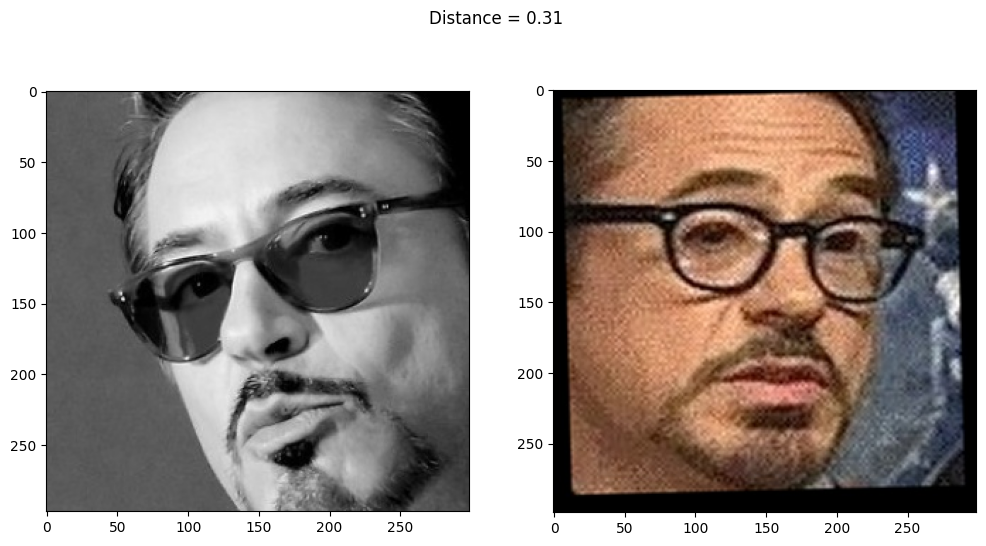

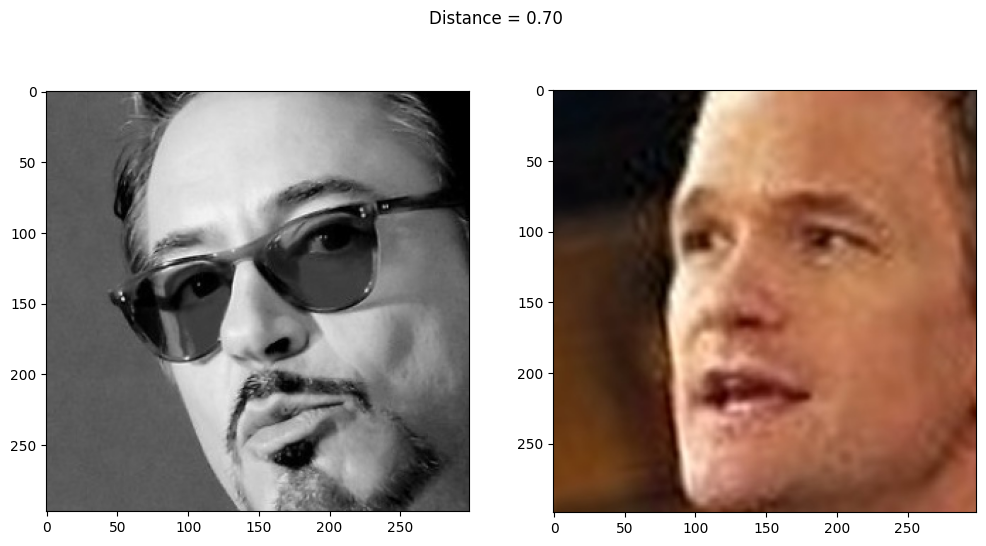

In [102]:
# Calling similar images and different images by passing the image number
plot_distance_btw_pair_image(15,16)
plot_distance_btw_pair_image(15,357)

Split into Train/Test

In [103]:
# Prepare the X_train, y_train, and also ensure that each label is present in both train and test
train_idx = np.arange(metaInformation_df.shape[0]) % 9 != 0
test_idx = np.arange(metaInformation_df.shape[0]) % 9 == 0
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]
targets = metaInformation_df['Label']
y_train = targets[train_idx]
y_test = targets[test_idx]

In [104]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


Encode the labels

In [106]:
# Convert it into numbers using label encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [107]:
print(le.classes_)

['Aaron Paul' 'Alvaro Morte' 'Amanda Crew' 'Amaury Nolasco' 'Anna Gunn'
 'Benedict Cumberbatch' 'Betsy Brandt' 'Brenton Thwaites' 'Brit Marling'
 'Bryan Cranston' 'Caity Lotz' 'Cameron Monaghan' 'Chance Perdomo'
 'Chris Evans' 'Chris Pratt' 'Cobie Smulders' 'Danielle Panabaker'
 'Dave Franco' 'Dominic Purcell' 'Dwayne Johnson' 'Emilia Clarke'
 'Emily Bett Rickards' 'Emma Stone' 'Gwyneth Paltrow' 'Henry Cavil'
 'Jason Momoa' 'Jeremy Renner' 'Jesse Eisenberg' 'Jim Parsons'
 'Jon Bernthal' 'Josh Radnor' 'Kit Harington' 'Krysten Ritter'
 'Kumail Nanjiani' 'Maisie Williams' 'Mark Ruffalo' 'Martin Starr'
 'Melissa benoit' 'Mike Colter' 'Morena Baccarin' 'Morgan Freeman'
 'Natalie Portman ' 'Neil Patrick Harris' 'Paul Rudd' 'Pedro Alonso'
 'Peter Dinklage' 'RJ Mitte' 'Rami Melek' 'Robert Knepper' 'Robin Taylor'
 'Ryan Reynolds' 'Sarah Wayne Callies' 'Scarlett Johansson'
 'Sebastian Stan' 'Sophie Turner' 'Stephen Amell' 'Sundar Pichai'
 'Thomas Middleditch' 'Tom Cavanagh' 'Ursula Corbero' 'Wen

In [108]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [92 92 92 ... 33 33 33]
y_test_encoded :  [92 92 92 ... 33 33 33]


In [109]:
#Scale the dataset using standard scaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#### **6. Use PCA for dimensionality reduction.**

In [110]:
# Using PCA, reduce the number of features
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#### **7. Build an SVM classifier in order to map each image to its right person.**

In [111]:
# SVC with default parameters
svc = SVC()
svc.fit(X_train_pca, y_train_encoded)

SVC()

In [112]:
# Predict the Result
y_predict = svc.predict(X_test_pca)

In [113]:
# Find the classification accuracy
print("Accuracy is ", accuracy_score(y_test_encoded, y_predict))

Accuracy is  0.9732664995822891


#### **8. Import and display the the test images.**

Hint: 'Benedict Cumberbatch9.jpg' and 'Dwayne Johnson4.jpg' are the test images.

In [114]:
def sample_img_plot(path):
  # Load image for sample_idx from test data
  sample_img = load_image(path)
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = scaler.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = le.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, pred_name

In [117]:
# Path of the images
Benedict_Cumberbatch9_img= "/content/drive/MyDrive/AIML DATASETS/Benedict Cumberbatch9.jpg"
Dwayne_Johnson4_img= "/content/drive/MyDrive/AIML DATASETS/Dwayne Johnson4.jpg"

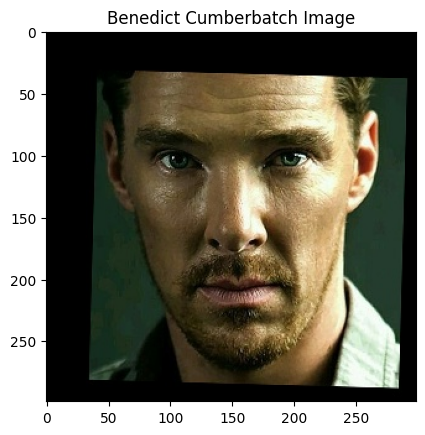

In [126]:
# Display Benedict Cumberbatch's image
image_path = Benedict_Cumberbatch9_img
image = plt.imread(image_path)
plt.title("Benedict Cumberbatch Image")
plt.imshow(image)
plt.show()

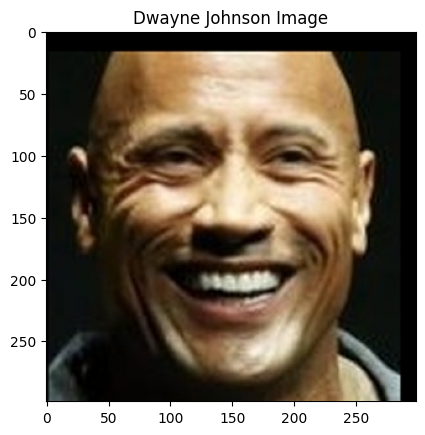

In [127]:
# Display Dwayne Johnson's image
image_path = Dwayne_Johnson4_img
image = plt.imread(image_path)
plt.title("Dwayne Johnson Image")
plt.imshow(image)
plt.show()

### **9. Use the trained SVM model to predict the face on both test images.**

1/1 [==============================] - 0s 24ms/step


Actual image is: Benedict Cumberbatch
Predicted image is: Benedict Cumberbatch




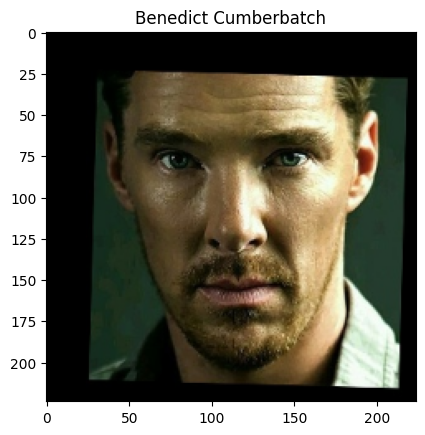

In [143]:
img, pred_name = sample_img_plot(Benedict_Cumberbatch9_img)
plt.imshow(img)
plt.title("Benedict Cumberbatch")
print('\n')
print("Actual image is: {}".format("Benedict Cumberbatch"))
print("Predicted image is: {}".format(pred_name))
print('\n')
plt.show()


1/1 [==============================] - 0s 26ms/step


Actual image is: Dwayne Johnson
Predicted image is: Dwayne Johnson




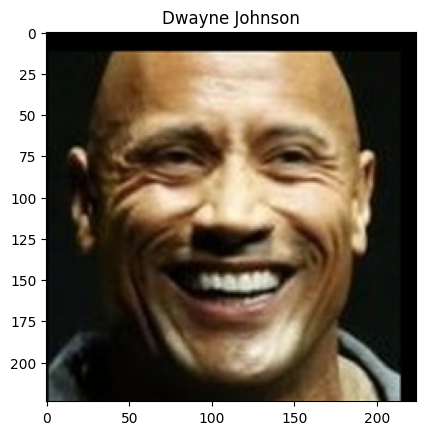

In [144]:
img, pred_name = sample_img_plot(Dwayne_Johnson4_img)
plt.imshow(img)
plt.title("Dwayne Johnson")
print('\n')
print("Actual image is: {}".format("Dwayne Johnson"))
print("Predicted image is: {}".format(pred_name))
print('\n')
plt.show()